In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Set seed for reproducibility
torch.manual_seed(42)

In [6]:
#sample datapoints from a normal distribution around 0

mean = [0, 0]
cov = [[0.4, 0], [0, 0.4]]  # Identity covariance matrix for simplicity

# Generate 1000 sample data points from a 2D normal distribution
sample_data = np.random.multivariate_normal(mean, cov, 100000)

# Filter points to ensure they are at least 0.1 apart
filtered_points = [sample_data[0]]  # Initialize with the first point

for point in sample_data[1:]:
    min_distance = min(np.linalg.norm(point - existing_point) for existing_point in filtered_points)
    if min_distance >= 0.6:
        filtered_points.append(point)

filtered_points = np.array(filtered_points)

In [7]:
def softmax_w(x, t):
    x = x / t
    x = x - torch.max(x, dim=1, keepdim=True)[0]
    return (torch.exp(x)+1e-4) / torch.sum(torch.exp(x), dim=1, keepdim=True)
        

def soft_top_k(x,t,k):
    y = torch.zeros_like(x)
    z = torch.zeros_like(x)

    x_w = x * (1 - y)
    x_w_softmax = softmax_w(x_w,t)
    y = y+x_w_softmax

    for k in range(k):
        #y = y - torch.diag(y.diagonal()) + torch.eye(x.size(0), device=x.device)
        y.fill_diagonal_(1)
        x_w = x * (1 - y)
        x_w_softmax = softmax_w(x_w,t)
        y = y+x_w_softmax
        z = z+x_w_softmax
        
    return z

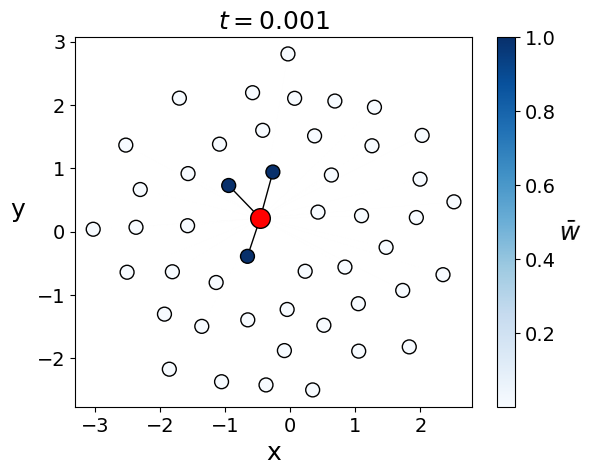

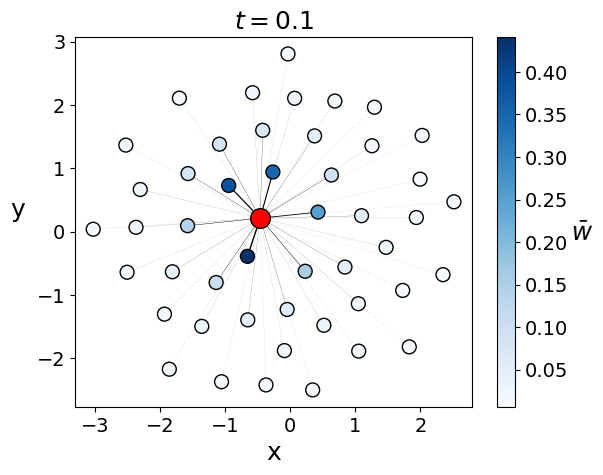

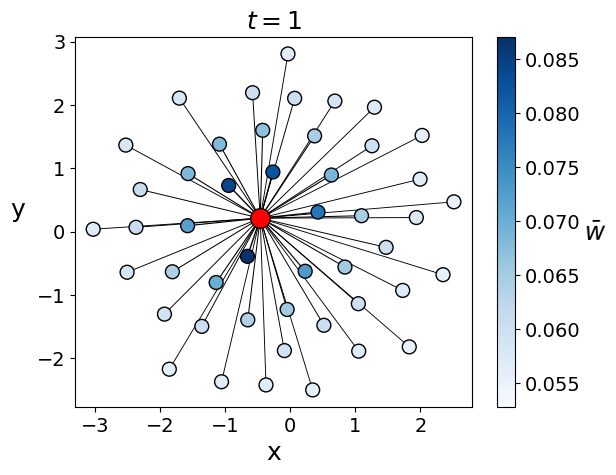

In [8]:
#compute w for the xknn1 for 3 different temperatures

filtered_points=torch.Tensor(filtered_points)
dist = torch.cdist(filtered_points, filtered_points)
dist=torch.exp(-dist)

distances = np.linalg.norm(filtered_points, axis=1)
select_datapoint=np.argmin(distances)

t_list=[1e-3,1e-1,1]

for i,t in enumerate(t_list):
#t=1e-10
    k=3
    w = soft_top_k(dist,t,k)
    
    #print(torch.max(w))
    
    topk_indices = torch.topk(w[select_datapoint, :], k=len(w[select_datapoint, :]), dim=0)[1]
        
    plt.figure()
    plt.title(r'$t=$%s'%t,fontsize=18)
    
    # Draw lines between selected data point and top indices
    for index in topk_indices:
        # Draw the line
        plt.plot([filtered_points[select_datapoint, 0], filtered_points[index, 0]],
                 [filtered_points[select_datapoint, 1], filtered_points[index, 1]],
                 linewidth=w[select_datapoint, index]/torch.max(w[select_datapoint, :]),color='k', linestyle='-', zorder=1) 
        
    scatter = plt.scatter(filtered_points[:, 0], filtered_points[:, 1], c=w[select_datapoint, :], edgecolor='k',s=100, cmap='Blues', zorder=2)
    cbar = plt.colorbar(scatter)
    cbar.set_label(r'$\bar{w}$', rotation=1, labelpad=10,fontsize=18)
    cbar.ax.tick_params(labelsize=14)

    plt.scatter(filtered_points[select_datapoint, 0], filtered_points[select_datapoint, 1], c='r', edgecolor='k',s=200,alpha=1, zorder=10)

    
        
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('x',fontsize=18)
    plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
    plt.show()